In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns
# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import decomposition
from sklearn import decomposition, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from Hackaton.python.read_pics import get_pics_from_file


In [3]:
mean_dic = dict()
pics_name = os.listdir('Hackaton/data/')

pics_no_key, info = get_pics_from_file(f'Hackaton/data/pics_NOKEY.bin')
signal_no = np.array(pics_no_key)

mean_dic['pics_NOKEY.bin'] = signal_no.mean(axis=0)


Ouverture du fichier de pics Hackaton/data/pics_NOKEY.bin


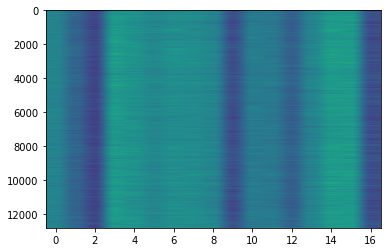

In [4]:
plt.imshow(signal_no, aspect="auto")

In [5]:
noise = mean_dic['pics_NOKEY.bin']

In [6]:
pics_dic = {'pics_0.bin': 1, 'pics_1.bin': 2, 'pics_2.bin': 2, 'pics_3.bin': 2,
 'pics_4.bin': 2, 'pics_5.bin': 9, 'pics_6.bin': 9, 'pics_7.bin': 9,
 'pics_8.bin': 9, 'pics_9.bin': 9, 'pics_A.bin': 14, 'pics_B.bin': 10,
 'pics_C.bin': 13, 'pics_CTRL.bin': 4, 'pics_D.bin': 13, 'pics_E.bin': 13,
 'pics_ENTER.bin': 2, 'pics_F.bin': 7, 'pics_G.bin': 8, 'pics_H.bin': 10,
 'pics_I.bin': 11, 'pics_J.bin': 10, 'pics_K.bin': 11, 'pics_L.bin': 12,
'pics_M.bin': 0, 'pics_N.bin': 8,
 'pics_O.bin': 12, 'pics_P.bin': 0, 'pics_Q.bin': 14, 'pics_R.bin': 7, 'pics_S.bin': 6,
 'pics_SHIFT.bin': 5, 'pics_SPACE.bin': 6, 'pics_SUPPR.bin': 1, 'pics_T.bin': 8, 'pics_U.bin': 10,
 'pics_V.bin': 7, 'pics_W.bin': 14, 'pics_X.bin': 6, 'pics_Y.bin': 8, 'pics_Z.bin': 6}


for pic_name in pics_name:
    pics_key, info = get_pics_from_file(f'Hackaton/data/{pic_name}')
    if pic_name != 'pics_NOKEY.bin':
        signal = (np.array(pics_key) - noise).clip(min=0)
        mean_dic[pic_name] = signal.mean(axis=0)





Ouverture du fichier de pics Hackaton/data/pics_0.bin
Ouverture du fichier de pics Hackaton/data/pics_1.bin
Ouverture du fichier de pics Hackaton/data/pics_2.bin
Ouverture du fichier de pics Hackaton/data/pics_3.bin
Ouverture du fichier de pics Hackaton/data/pics_4.bin
Ouverture du fichier de pics Hackaton/data/pics_5.bin
Ouverture du fichier de pics Hackaton/data/pics_6.bin
Ouverture du fichier de pics Hackaton/data/pics_7.bin
Ouverture du fichier de pics Hackaton/data/pics_8.bin
Ouverture du fichier de pics Hackaton/data/pics_9.bin
Ouverture du fichier de pics Hackaton/data/pics_A.bin
Ouverture du fichier de pics Hackaton/data/pics_B.bin
Ouverture du fichier de pics Hackaton/data/pics_C.bin
Ouverture du fichier de pics Hackaton/data/pics_CTRL.bin
Ouverture du fichier de pics Hackaton/data/pics_D.bin
Ouverture du fichier de pics Hackaton/data/pics_E.bin
Ouverture du fichier de pics Hackaton/data/pics_ENTER.bin
Ouverture du fichier de pics Hackaton/data/pics_F.bin
Ouverture du fichier 

Ouverture du fichier de pics Hackaton/data/pics_LOGINMDP.bin


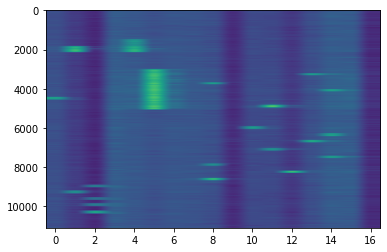

In [7]:
pics_login, info = get_pics_from_file(f'Hackaton/data/pics_LOGINMDP.bin')
array = np.array(pics_login)
plt.imshow(array, aspect="auto")

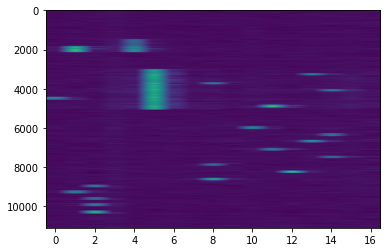

In [8]:
array -= noise
array = array.clip(min=0)
plt.imshow(array, aspect="auto")

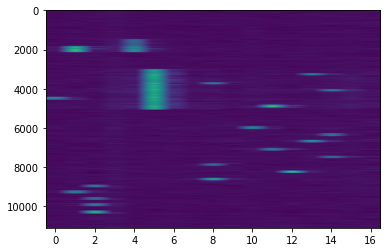

In [9]:

copy = np.copy(array)
original = np.copy(copy)
plt.imshow(copy, aspect="auto")

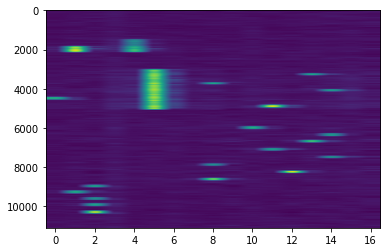

In [10]:
from scipy.ndimage import gaussian_filter1d
gf = gaussian_filter1d(copy, 10, 0)
plt.imshow(gf, aspect="auto")


In [11]:
pics_key_login, info = get_pics_from_file(f'Hackaton/data/pics_LOGINMDP.bin')
original_signal = (np.array(pics_key_login) - signal_no.mean(axis=0)).clip(min=0)

Ouverture du fichier de pics Hackaton/data/pics_LOGINMDP.bin


In [112]:
import re


def to_keys(x):
    return [([(re.search('pics_(.*).bin', key).group(1)) for key in keys[0]], keys[1]) for keys in x]


def translate(results):
    text = ""
    count = 0
    for i, _inputs in enumerate(results):
        keys, proba = _inputs

        if len(keys) == 0:
            continue

        if i > 0 and sorted(keys) == sorted(results[i - 1][0]):
            count += 1
        elif len(keys) == 1 and len(keys[0]) == 1:
            text += "".join(keys).lower()
        elif "SHIFT" in keys and len(keys) == 2:
            text += "".join([key for key in keys if key != "SHIFT"]).upper()
        else:
            text += " ".join(keys).upper()

        if i == len(results)-1 or sorted(keys) != sorted(results[i + 1][0]):
            if count > 0:
                text += " [" + str(count) + "]"
                count = 0
            text += " (" + str(proba) + ")\n"
    return text


In [117]:
predictions = []
n_line = 4900
res = (0, 'pics_NOKEY.bin')
for n_line in range(0, 11000):
    all_combinaisons = []
    for i in range(gf.shape[1]):
        if gf[n_line][i] > 0.7 and i != 15 and i != 3 and i != 16:
            all_combinaisons.append([k for k,v in pics_dic.items() if v == i])

    if all_combinaisons:
        a = gf[n_line]
        combinaisons = list(itertools.product(*all_combinaisons))
        minlist = np.zeros(len(combinaisons))


        for i, combinaison in enumerate(combinaisons):
            to_predict = np.copy(original_signal[n_line])
            for j in combinaison:
                to_predict = (to_predict - mean_dic[j]).clip(min=0)
            minlist[i] = np.sum(np.absolute(np.zeros(17) - to_predict))

        predictions.append((list(combinaisons[np.argmin(minlist)]), 1/len(combinaisons)))


In [118]:
predictions = to_keys(predictions)


In [119]:
print(translate(predictions))


CTRL [25] (1.0)
SUPPR CTRL [8] (0.5)
0 CTRL (0.5)
SUPPR CTRL [84] (0.5)
0 CTRL (0.5)
SUPPR CTRL [30] (0.5)
0 CTRL (0.5)
SUPPR CTRL [27] (0.5)
0 CTRL (0.5)
SUPPR CTRL [26] (0.5)
0 CTRL (0.5)
SUPPR CTRL [109] (0.5)
SUPPR [4] (0.5)
SHIFT [218] (1.0)
C [28] (0.3333333333333333)
D (0.3333333333333333)
C [41] (0.3333333333333333)
SHIFT [389] (1.0)
N [5] (0.25)
Y (0.25)
N [3] (0.25)
T (0.25)
N [3] (0.25)
Y [1] (0.25)
N [5] (0.25)
Y (0.25)
N (0.25)
T (0.25)
Y (0.25)
N [1] (0.25)
Y (0.25)
N (0.25)
Y (0.25)
N [10] (0.25)
Y (0.25)
N [1] (0.25)
Y (0.25)
N [3] (0.25)
Y [1] (0.25)
N [2] (0.25)
Y (0.25)
G (0.25)
Y (0.25)
N [1] (0.25)
T (0.25)
N [10] (0.25)
Y (0.25)
SHIFT [272] (1.0)
A [2] (0.3333333333333333)
W [1] (0.3333333333333333)
Q (0.3333333333333333)
W [4] (0.3333333333333333)
A (0.3333333333333333)
W [4] (0.3333333333333333)
A (0.3333333333333333)
W (0.3333333333333333)
A (0.3333333333333333)
W (0.3333333333333333)
A (0.3333333333333333)
W (0.3333333333333333)
A (0.3333333333333333)
W (0.333

In [ ]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(distance_threshold=2, n_clusters=None, compute_full_tree=True)
y_pred = clustering.fit_predict(to_cluster)
print(clustering.n_clusters_)

from itertools import cycle, islice
colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                     '#f781bf', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
plt.scatter(to_cluster[:, 1], np.full((to_cluster.shape[0], 1), 2000), s=10, color=colors[y_pred])
plt.gca().invert_yaxis()

In [ ]:
from skimage.filters import threshold_otsu


thresh = threshold_otsu(copy)
print(thresh)


copy = (copy > thresh).astype(int)
plt.imshow(copy, aspect="auto")

In [ ]:
plt.hist(copy.ravel(), bins=256)
plt.axvline(thresh, color='r')

In [ ]:
pics_name = os.listdir('Hackaton/data/')
pics_name.remove('pics_LOGINMDP.bin')


In [ ]:
pics_h, info = get_pics_from_file(f'Hackaton/data/pics_H.bin')
signal_h = np.array(pics_h) - signal_no.mean()
signal_h = signal_h.clip(min=0)
plt.imshow(signal_h, aspect="auto")

In [ ]:
pics_ctrl, info = get_pics_from_file(f'Hackaton/data/pics_CTRL.bin')
signal_ctrl = np.array(pics_ctrl) - signal_no.mean()
signal_ctrl = signal_ctrl.clip(min=0)
plt.imshow(signal_ctrl, aspect="auto")

## Transform to panda dataset


In [ ]:
noise = signal_no.mean()

In [ ]:
pics_name = os.listdir('Hackaton/data/')
pics_name.remove('pics_LOGINMDP.bin')
data = dict()
for i in range(17):
    data[str(i)] = []
data["name"] = []

for pic_name in pics_name:
    pics_key, info = get_pics_from_file(f'Hackaton/data/{pic_name}')
    for pics in pics_key:
        for i, pic in enumerate(pics):
            data[str(i)].append(pic - noise)
        data["name"].append(pic_name)

df = pd.DataFrame(data)
df.head(6)


In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, 17]

print("X shape = " + str(X.shape))
print("y shape = " + str(y.shape))

In [ ]:
# List of name (X)


In [ ]:
# Normalize
#normalizer = Normalizer()
#X = normalizer.fit_transform(X)

# Standardize
#scaler = StandardScaler()
#X = scaler.fit_transform(X)






In [ ]:
pca = decomposition.PCA()
pca.fit(X)
plt.figure(figsize=(10,8))
plt.plot(range(1, 18), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')

In [ ]:
minidf = df.loc[(df["name"] == "pics_1.bin") | (df["name"] == "pics_2.bin") | (df["name"] == "pics_5.bin")]
sns.lmplot(x="2", y="6",
  data=minidf,
  fit_reg=False,
  hue='name', # color by cluster
  legend=True,
  scatter_kws={"s": 1}) # specify the point size



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, shuffle=True)

In [ ]:
# KNN
K = 30

# Create and fit model
neigh = KNeighborsClassifier(n_neighbors=K, weights="distance", n_jobs=-1)
neigh.fit(X_train, y_train)



In [ ]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(X_train, y_train)


In [ ]:
# Test
y_pred = clf.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
# Test
print(neigh.score(X_test, y_test))
# y_pred = neigh.predict(X_test)
#print(metrics.accuracy_score(y_test, y_pred))


In [ ]:
from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(clf, X_test, y_test,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title('Normalized confusion matrix')

In [ ]:
# Test
pics_key, info = get_pics_from_file(f'Hackaton/data/pics_LOGINMDP.bin')
predictions = []
predictions_proba = []
for pics in pics_key:
    key = clf.predict(pics.reshape(1, -1))[0]
    if key != 'pics_NOKEY.bin':
        predictions.append(key)
print()

In [ ]:
for pic_name in pics_name:
    print(f'{pic_name} : {predictions.count(pic_name)}')
print(len(predictions))

In [ ]:
reconstruct = res = list(filter('pics_NOKEY.bin'.__ne__, predictions))
print(reconstruct)

In [ ]:
print(predictions)
